In [1]:
import numpy as np 
import cvxpy
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
X = np.zeros((20,100,3),dtype='uint8')
Y = np.zeros((20,100,3),dtype='uint8')

for i in range(9,21):
    X[:,i] = 255
for i in range(79,91):
    Y[:,i] = 255

In [24]:
# この画像XをYに動かす最適輸送Pを求める
Image.fromarray(X)

In [4]:
Image.fromarray(Y)

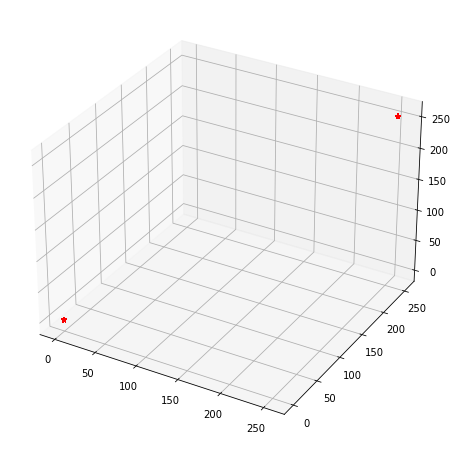

In [25]:
# Xの各ピクセルのRGBをプロットしたもの（白黒なので両極端，しかもピクセルが重複しまくっている）
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,:,0], X[:,:,1], X[:,:,2], c="red", marker="*")

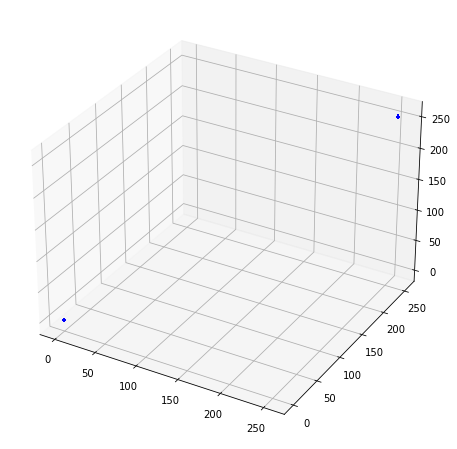

In [26]:
# Yの各ピクセルのRGBをプロットしたもの（白黒なので両極端，しかもピクセルが重複しまくっている）
# Xの分布と同じに見えるが，どのピクセルが[R,G,B] = [0,0,0]かなどは異なっているので注意
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Y[:,:,0], Y[:,:,1], Y[:,:,2], c="blue", marker="+")

In [27]:
X.shape

(20, 100, 3)

In [28]:
Height = X.shape[0]
Width = X.shape[1]
Num = Height*Width

In [29]:
Num

2000

In [30]:
# コスト行列
# これを変えることによって最適輸送が変わる．
C1 = np.zeros((Num, Num)) 
C2 = np.zeros((Num, Num)) 

In [31]:
for i in range(Num):
    for j in range(Num):
        # コスト行列C1はピクセルの座標はまったく考慮せずに，カラーの違いだけを測る感じ
        C1[i][j] = np.sqrt( (( (X[i//Width][i%Width] - Y[j//Width][j%Width])/255 )**2).sum() )
        # コスト行列C2はピクセルの座標の違いと，カラーの違いを測る感じ
        C2[i][j] = np.sqrt( ( ((i//Width)-(j//Width))/Width )**2 + ( ((i%Width)-(j%Width))/Height )**2 + (( (X[i//Width][i%Width] - Y[j//Width][j%Width])/255 )**2).sum() )
#        C[i][j] = np.sqrt( ((i//X_w)-(j//ref_w))**2 + ((i%X_w)-(j%ref_w))**2 )
#        C[i][j] = ((X[i//X_h][i%X_w] - ref[j//ref_h][j%ref_w])**2).sum()

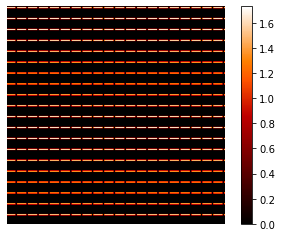

In [32]:
plt.imshow(C1, cmap=plt.cm.gist_heat)
plt.axis('off')
plt.colorbar()

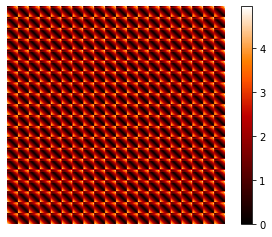

In [33]:
plt.imshow(C2, cmap=plt.cm.gist_heat)
plt.axis('off')
plt.colorbar()

In [34]:
a1 = np.ones(Num)/Num
b1 = np.ones(Num)/Num

a2 = np.ones(Num)/Num
b2 = np.ones(Num)/Num

In [35]:
eps = 0.005

# コストC1に対する最適輸送を求めるためのShinkhornアルゴリズム
K1 = np.exp(-C1/eps)
u1 = np.ones(Num)

for i in range(1000):
    v1 = b1 / (K1.T @ u1)
    u1 = a1 / (K1 @ v1)

f1 = eps*np.log(u1 + 1e-9)
g1 = eps*np.log(v1 + 1e-9)
    
P1 = u1.reshape(Num,1) * K1 * v1.reshape(1,Num)


# コストC1に対する最適輸送を求めるためのShinkhornアルゴリズム
K2 = np.exp(-C2/eps)
u2 = np.ones(Num)

for i in range(1000):
    v2 = b2 / (K2.T @ u2)
    u2 = a2 / (K2 @ v2)

f2 = eps*np.log(u2 + 1e-9)
g2 = eps*np.log(v2 + 1e-9)
    
P2 = u2.reshape(Num,1) * K2 * v2.reshape(1,Num)

In [36]:
# x = cvxpy.Variable((X_dim, ref_dim), nonneg=True)
# objective = cvxpy.sum(cvxpy.multiply(C,x))
# constraints = []
# constraints += [cvxpy.sum(x[i,:]) == a[i] for i in range(len(a))]
# constraints += [cvxpy.sum(x[:,j]) == b[j] for j in range(len(b))]
# constraints += [x>=0]
# prob = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
# prob.solve()
# P = x.value

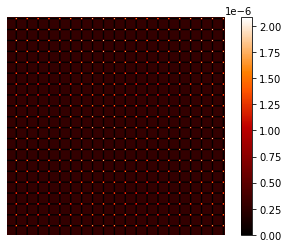

In [37]:
plt.imshow(P1, cmap=plt.cm.gist_heat)
plt.axis('off')
plt.colorbar()
# Xの白いところをYの白いところに移している
# 移すときのピクセル間の距離のコストは無いので，色合いさえ一緒なら，問題なく動かすことができる．

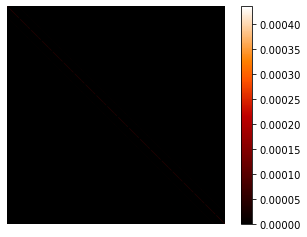

In [38]:
plt.imshow(P2, cmap=plt.cm.gist_heat)
plt.axis('off')
plt.colorbar()
# Xから何も動かさない，という最適輸送になっている．
# 移すときの「ピクセル間の距離のコスト」が「色合いがあっているというコスト」を上回っているため，動かさない選択をしている．
# おそらく「ピクセル間の距離のコスト」と「色合いがあっているというコスト」の比重を変えると，どこかでP1に切り替わるはず．

In [39]:
# あんまり意味は無いけど
# 各最適輸送を使って，XをYに変換する手続き

# 最適輸送P1によってXを輸送した場合
Y_tp_1 = np.zeros((Height, Width, 3),dtype='uint8')

# 最適輸送P2によってXを輸送した場合
Y_tp_2 = np.zeros((Height, Width, 3),dtype='uint8')

In [40]:
for j in range(Num):
    a_i = np.zeros(3)
    for i in range(Num):
        a_i += P1[i][j]*X[i//Width][i%Width]*Num
    Y_tp_1[j//Width][j%Width] = a_i

    
for j in range(Num):
    a_i = np.zeros(3)
    for i in range(Num):
        a_i += P2[i][j]*X[i//Width][i%Width]*Num
    Y_tp_2[j//Width][j%Width] = a_i
    

In [41]:
Image.fromarray(Y_tp_1)

In [42]:
Image.fromarray(Y_tp_2)